# Loading libraries and functions

In [1]:
%%capture
!pip install neurodsp
!pip install emd
!pip install tslearn
!pip install dtaidistance

In [2]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy

In [3]:
def load_mat_data(path_to_data, file_name, states_file):
  data = loadmat(path_to_data + file_name)
  data = data['PFClfpCleaned'].flatten()

  states = loadmat(path_to_data + states_file)
  states = states['states'].flatten()
  return data, states

In [4]:
def get_first_NREM_epoch(arr, start):
  start_index = None
  for i in range(start, len(arr)):
    if arr[i] == 3:
      if start_index is None:
        start_index = i
    elif arr[i] != 3 and start_index is not None:
      return (start_index, i - 1, i)

  return (start_index, len(arr) - 1, len(arr)) if start_index is not None else None

def get_all_NREM_epochs(arr):
  nrem_epochs = []
  next_start = 0
  while next_start < len(arr)-1:
    indices = get_first_NREM_epoch(arr, next_start)
    if indices == None:
      break
    start, end, next_start = indices
    if end-start <= 30:
      continue
    nrem_epochs.append([start, end])
  return nrem_epochs

In [5]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

# Compute metrics for each cycle -
#     Maximum Amplitude
#     Cycle Duration
#     Trough Position and values
#     Peak (just before the trough) Position and Values
#     Peak Position and Values
#     Peak-to-Trough Duration
def get_cycles_with_metrics(cycles, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('avg_amp', IA, func=np.mean)
  C.compute_cycle_metric('duration_samples', IA, func=len)

  C.compute_cycle_metric('trough_values', nrem_filtered_data, func=np.min)
  C.compute_cycle_metric('trough_position', nrem_filtered_data, func=np.argmin)

  C.compute_cycle_metric('peak_values', nrem_filtered_data, func=np.max)
  C.compute_cycle_metric('peak_position', nrem_filtered_data, func=np.argmax)

  C.compute_cycle_metric('peak_before_trough_val', nrem_filtered_data, func=peak_before_trough)
  C.compute_cycle_metric('peak_before_trough_pos', nrem_filtered_data, func=peak_before_trough_pos)
  C.compute_cycle_metric('peak_to_trough_duration', nrem_filtered_data, func=peak_to_trough_duration)

  C.compute_cycle_metric('num_inflection_points', nrem_filtered_data, func=num_inflection_points)
  return C

# Load data

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
# Loading sleep scoring data from MAT files stored in Google Drive.
path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
data_file = 'PFClfpCleaned.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'


# path_to_data = '/content/drive/My Drive/Donders Internship/data_13_CN/'
# data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
# states_file = '2019-05-13_11-24-48_post_trial1-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))
nrem_epochs

array([[ 873, 1592],
       [1681, 1974],
       [2016, 2080],
       [2133, 2179],
       [2192, 2347],
       [2356, 2445],
       [2606, 2932],
       [3075, 3251],
       [3279, 3366],
       [3450, 3552],
       [3667, 3710],
       [3728, 3796],
       [5370, 5412],
       [5440, 5501],
       [5518, 5602],
       [5609, 6047],
       [6112, 6267],
       [6333, 6394],
       [6417, 6604],
       [6637, 6721],
       [6728, 6823],
       [6870, 6916],
       [6928, 7044],
       [7084, 7151],
       [8583, 8671],
       [8684, 8747],
       [8781, 8954],
       [8982, 9117],
       [9190, 9314],
       [9345, 9427],
       [9574, 9737]])

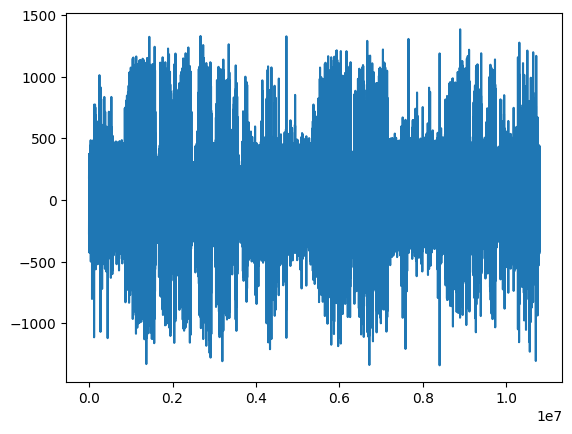

In [8]:
plt.plot(pfc_data);

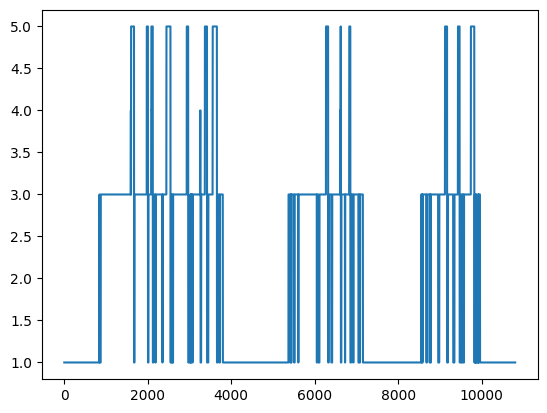

In [9]:
plt.plot(sleep_scoring);

In [10]:
len(pfc_data)/len(sleep_scoring)

1000.0773076566985

# Get All Cycles

In [11]:
# Joining all the NREM epochs and filtering the Delta band

fs = 1000 # Sampling rate/frequency
nrem_data = []
for start, end in nrem_epochs:
  pfc_data_part = pfc_data[start*fs:end*fs]
  nrem_data.extend(pfc_data_part)
nrem_data = np.array(nrem_data)
nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)

# For testing, subset data
# nrem_filtered_data = nrem_filtered_data[:fs*60*10]

/usr/local/lib/python3.10/dist-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


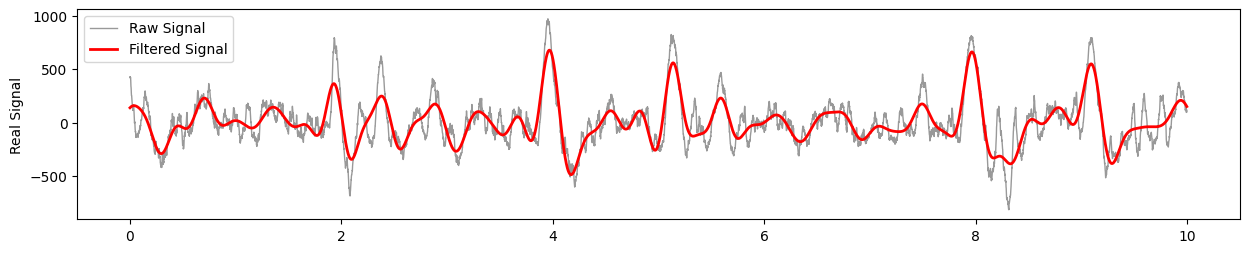

In [12]:
# Plot NREM filtered data (10 sec window)

start = fs*200 # Start position for signal
length = 10

t = np.arange(fs*length) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()

In [13]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

# Get cycles using IP
C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [14]:
def get_cycles_with_conditions(cycles, fs, conditions):
  C = copy.deepcopy(cycles)
  metrics = C.get_metric_dataframe()

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  peak_thresh = np.percentile(metrics['peak_before_trough_val'], 85)
  trough_thresh = np.percentile(metrics['trough_values'], 40)

  trough_min = np.mean(metrics['trough_values'])-np.std(metrics['trough_values'])*3
  peak_max = np.mean(metrics['peak_before_trough_val'])+np.std(metrics['peak_before_trough_val'])*3

  lo_freq_duration = fs/0.1
  hi_freq_duration = fs/4

  C.pick_cycle_subset(conditions)
  return C

In [15]:
cycles = get_cycles_with_metrics(C)

In [21]:
metrics = cycles.get_metric_dataframe()
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh = np.percentile(metrics['peak_before_trough_val'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)

trough_min = np.mean(metrics['trough_values'])-np.std(metrics['trough_values'])*3
peak_max = np.mean(metrics['peak_before_trough_val'])+np.std(metrics['peak_before_trough_val'])*3

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [22]:
conditions = ['is_good==1',
                # f'max_amp>{amp_thresh}',
                f'duration_samples<{lo_freq_duration}',
                f'duration_samples>{hi_freq_duration}',
                f'peak_to_trough_duration<=500',
                f'peak_to_trough_duration>=150',
                # f'peak_before_trough_val>={peak_thresh}',
                # f'trough_values>={trough_min}',
                # f'peak_before_trough_val<={peak_max}',
                f'trough_values<={trough_thresh}',
                # f'num_inflection_points<=3',
                ]
all_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [23]:
metrics = all_cycles.get_metric_dataframe(subset=True)
metrics

,index,is_good,max_amp,avg_amp,duration_samples,trough_values,trough_position,peak_values,peak_position,peak_before_trough_val,peak_before_trough_pos,peak_to_trough_duration,num_inflection_points,chain_ind
0,8,1,385.419236,310.075897,498,-385.061739,353,268.741512,137,268.741512,137,216,3,0
1,15,1,577.478296,364.151883,832,-464.338443,668,335.883058,262,324.340567,449,219,5,1
2,23,1,465.991827,310.375628,420,-372.621361,267,308.257680,95,308.257680,95,172,3,2
3,29,1,560.010542,336.936566,593,-372.123774,317,481.054485,119,481.054485,119,198,5,3
4,69,1,515.758008,407.229123,466,-392.530321,268,495.202314,93,495.202314,93,175,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,9983,1,468.194441,333.168017,624,-409.215842,233,193.802866,57,193.802866,57,176,4,1820
2686,9987,1,444.316463,291.343139,693,-440.601166,475,189.675638,248,189.675638,248,227,5,1821
2687,9990,1,487.763041,218.378678,783,-282.780497,595,197.334035,381,197.334035,381,214,3,1822
2688,10000,1,619.922038,504.221909,472,-619.121028,322,390.620448,107,390.620448,107,215,3,1823


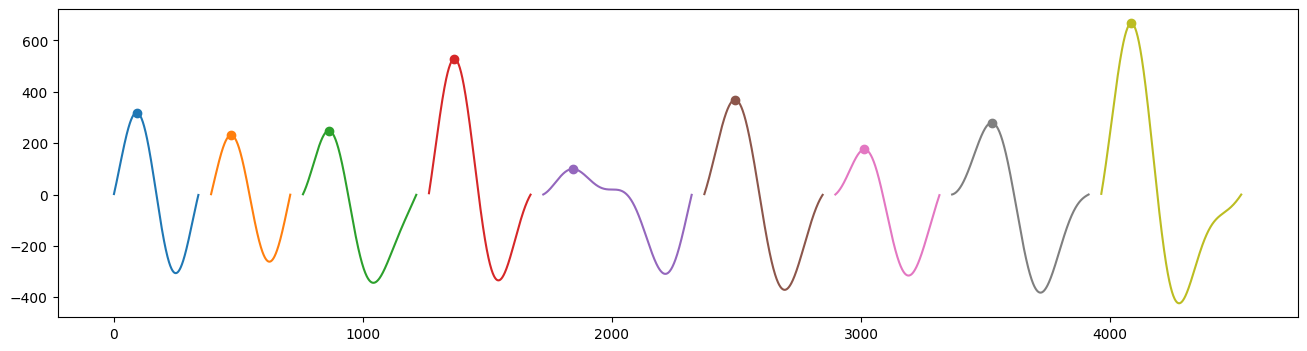

In [24]:
cycles_to_plot = metrics['index'][11:20]
plt.figure(figsize=(16,4))
start = 0
for ii in cycles_to_plot:
  inds = cycles.get_inds_of_cycle(ii)
  cycle = nrem_filtered_data[inds]
  row = metrics[metrics['index'] == ii]
  xinds = np.arange(len(inds)) + start
  plt.plot(xinds, cycle)
  plt.scatter(row['peak_before_trough_pos']+start, row['peak_before_trough_val'])

  start += len(inds)+50

In [33]:
fig = px.density_contour(metrics, x="peak_before_trough_val", y="trough_values", marginal_x="histogram", marginal_y="histogram")
fig.show()

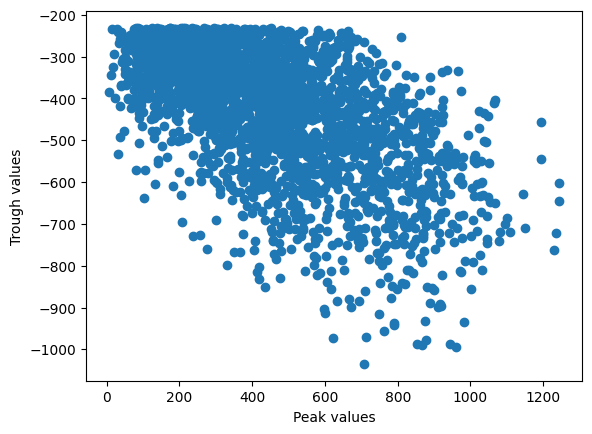

In [34]:
plt.scatter(metrics['peak_before_trough_val'], metrics['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# Get SO and delta cycles

In [25]:
conditions = ['is_good==1',
                # f'max_amp>{amp_thresh}',
                f'duration_samples<{lo_freq_duration}',
                f'duration_samples>{hi_freq_duration}',
                f'peak_to_trough_duration<=500',
                f'peak_to_trough_duration>=150',
                f'peak_before_trough_val>={peak_thresh}',
                # f'trough_values>={trough_min}',
                # f'peak_before_trough_val<={peak_max}',
                f'trough_values<={trough_thresh}',
                # f'num_inflection_points<=3',
                ]
so_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [26]:
conditions = ['is_good==1',
                # f'max_amp>{amp_thresh}',
                f'duration_samples<{lo_freq_duration}',
                f'duration_samples>{hi_freq_duration}',
                f'peak_to_trough_duration<=500',
                f'peak_to_trough_duration>=150',
                f'peak_before_trough_val<{peak_thresh}',
                # f'trough_values>={trough_min}',
                # f'peak_before_trough_val<={peak_max}',
                f'trough_values<={trough_thresh}',
                # f'num_inflection_points<=3',
                ]
delta_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [27]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

(0.0, 600.0)

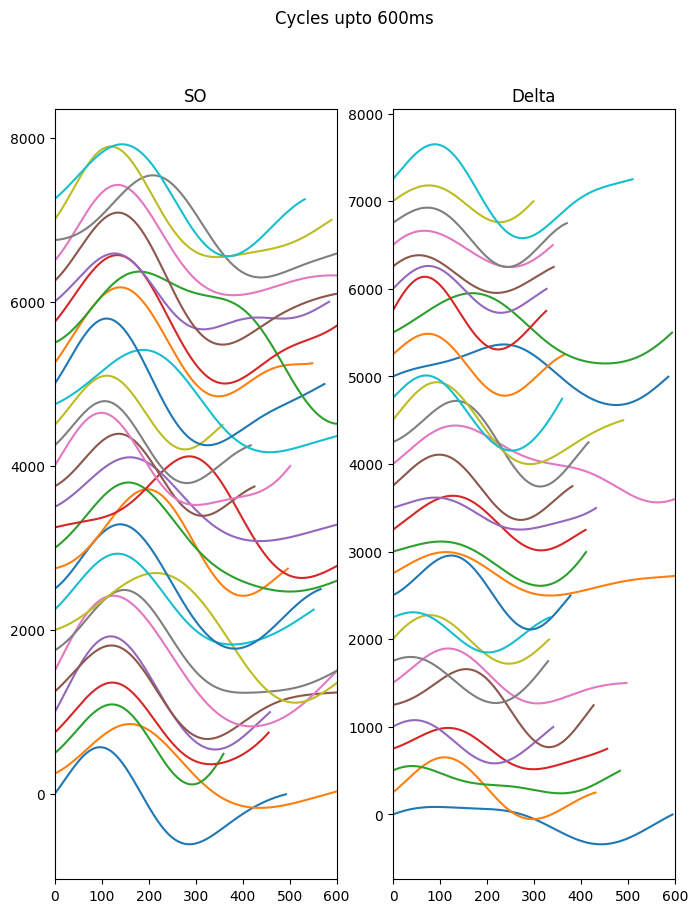

In [29]:
plt.figure(figsize=(8,10))
plt.suptitle("Cycles upto 600ms")

plt.subplot(1, 2, 1)
plt.title('SO')
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

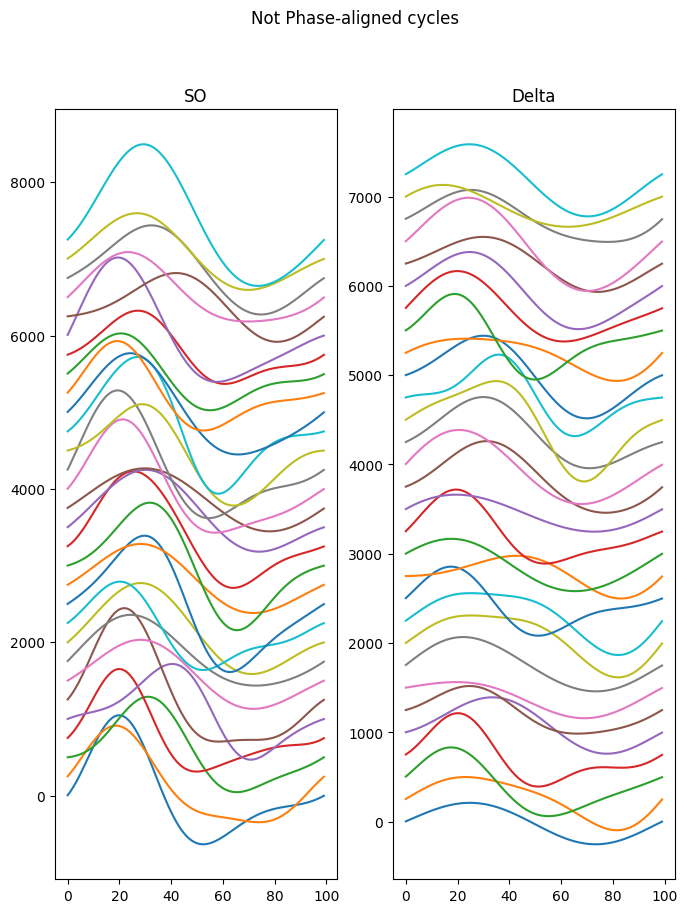

In [28]:
plt.figure(figsize=(8,10))
plt.suptitle("Not Phase-aligned cycles")

plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  # plt.plot(so_waveforms[:,i]+start)
  start += 250

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  start += 250

# Phase-aligned cycles

In [30]:
mask_so = np.zeros((len(IP)), dtype=bool)
mask_delta = np.zeros((len(IP)), dtype=bool)

for i in metrics_so['index']:
  for j in so_cycles.get_inds_of_cycle(i):
    mask_so[j] = True

for i in metrics_delta['index']:
  for j in delta_cycles.get_inds_of_cycle(i):
    mask_delta[j] = True

In [31]:
cycles_so = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask_so)
cycles_delta = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask_delta)
so_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=cycles_so, npoints=100)
delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=cycles_delta, npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


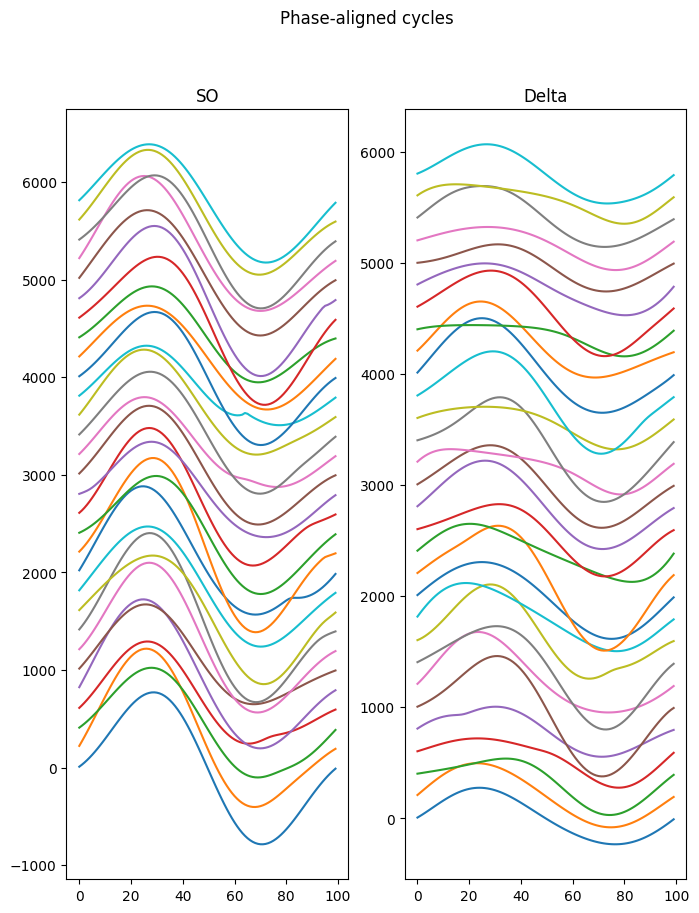

In [32]:
plt.figure(figsize=(8,10))
plt.suptitle("Phase-aligned cycles")
plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms[:,i]+start)
  start += 200

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(delta_waveforms[:,i]+start)
  start += 200

# PCA

In [52]:
# Joining all the NREM epochs and filtering the Delta band

fs = 1000 # Sampling rate/frequency
nrem_data = []
for start, end in nrem_epochs:
  pfc_data_part = pfc_data[start*fs:end*fs]
  nrem_data.extend(pfc_data_part)
nrem_data = np.array(nrem_data)
nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)

# For testing, subset data

/usr/local/lib/python3.10/dist-packages/neurodsp/filt/utils.py:90: RuntimeWarning:

divide by zero encountered in log10



In [82]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, 1000, 'hilbert')

cycles_temp = emd.cycles.get_cycle_vector(IP, return_good=True)
pa_waveform, phase_template = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=cycles_temp, npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


In [ ]:
pa_waveform = pa_waveform.T

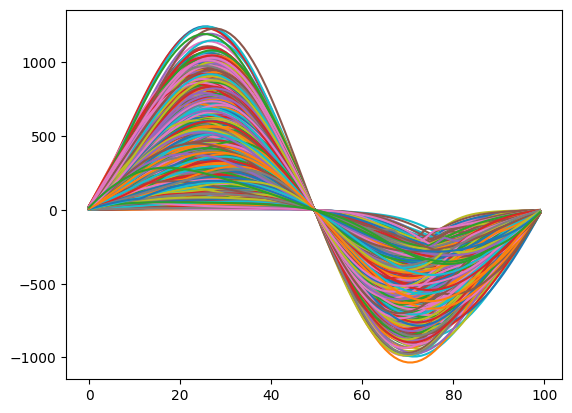

In [ ]:
plt.plot(pa_waveform.T);

In [476]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(pa_waveform.T)

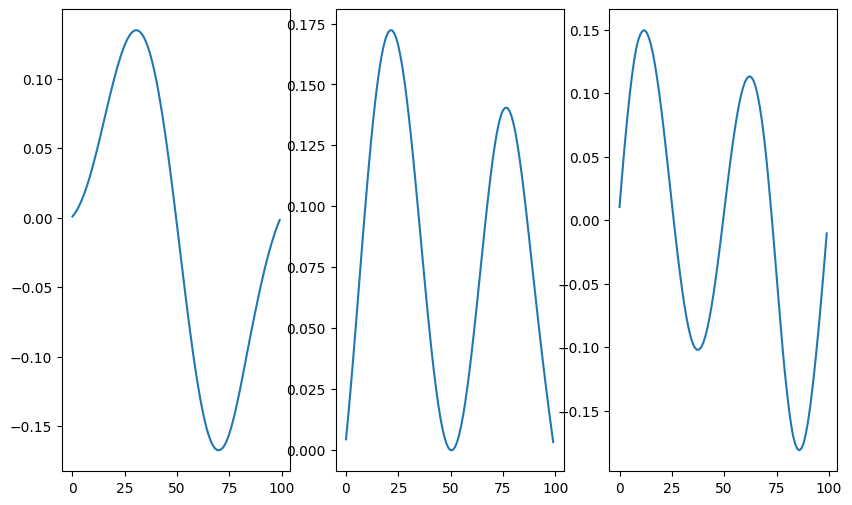

In [477]:
plt.figure(figsize=(10, 6))

for i in range(len(pca.components_)):
  plt.subplot(1, len(pca.components_), i+1)
  pc = pca.components_[i]
  plt.plot(pc, label='PC')